In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fpipe.pipeline.pipeline import run_pipeline
from fpipe.timestream import data_base as db 

from fpipe.timestream import rfi_flagging # to use sum beam flagging
from fpipe.timestream import sir_operate # to use sum beam flagging
from fpipe.timestream import freq_rebin

from fpipe.plot import plot_waterfall
from fpipe.plot import plot_rfi as pr
import numpy as np
import os

data_base = '/home/ycli/data/fanalysis/'
band_list = ['_1050-1150MHz', '_1150-1250MHz', '_1250-1450MHz']
tnoise_file = '/home/ycli/data/fast/tnoise/Tnoise_M_low.h5'


In [3]:
@run_pipeline
def sumthreshold_flagging():
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True
    
    feed_select = list(np.arange(1, 20))
    
    pipe_tasks.append(rfi_flagging.Flag)
    
    rf_input_files = [] #['bpcal/%s'%f for f in input_files]
    rf_output_files = [] #[ 'sumthreshold_flagging_sumfeeds/%s'%(f, ) for f in input_files ]
    rf_show_grogress = True
    rf_corr = 'auto'
    rf_process_timing = True
    rf_first_threshold = 10.0
    # rf_distribution = 'Gaussian'
    rf_tk_size = 0.01
    rf_fk_size = 100.0
    rf_feed_select = feed_select
    
    #rf_flag_direction = ('time',)
    rf_flag_direction = ('freq',)
    rf_max_threshold_length = 256
    #rf_max_threshold_length = 128
    
    rf_threshold_num = 5
    #rf_bad_freqs = [[1160, 1190], [1200, 1220], [1250, 1300]]
    rf_bad_freqs  = [[1156.45, 1217.14], [1225.6, 1229.6], [1244.0, 1249.06],
                     [1258.52, 1293.75]]
    rf_rfi_hist = None #data_base +  '/rfi_hist/sth_sumfeeds_%s_%s%s.h5'%(DATE, DATA, suffix)
    
    return locals()

@run_pipeline
def sir_flagging():
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True
    
    feed_select = list(np.arange(1, 20))    
    
    pipe_tasks.append(sir_operate.Sir)
    
    sir_input_files = [] #rf_output_files
    sir_feed_select = feed_select
    sir_corr = 'auto'
    sir_show_grogress = True
    sir_process_timing = True
    sir_eta = 0.05
    sir_output_files = [] #[ 'sir_flagging_sumfeeds/%s'%f for f in input_files ]
    
    return locals()

@run_pipeline
def rebin_frequency():
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True
    
    feed_select = list(np.arange(1, 20))
    
    pipe_tasks.append(freq_rebin.Rebin)
    
    rb_input_files = [] #sir_output_files
    rb_corr = 'auto'
    rb_process_timing = True
    rb_output_files = [] #[ 'rb4_sumfeeds_nocal/%s'%(f, ) for f in input_files ]
    rb_bin_combine_number = 4
    
    return locals()

@run_pipeline
def plot_wf():
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True
    
    feed_select = list(np.arange(1, 20))

    pipe_tasks.append((plot_waterfall.PlotMeerKAT, 'pkat1_'))
    
    pkat1_input_files  = [] #['%s/%s'%('bpcal', f,) for f in input_files]
    pkat1_re_scale  = 2.0 #2.0 #0.2
    pkat1_main_data = 'vis'
    pkat1_fig_name  = '' #'wf/%s_%s%s'%('bpcal', DATA_Key, suffix)
    pkat1_flag_mask = True
    pkat1_flag_ns   = True
    pkat1_flag_raw  = False
    pkat1_plot_ra = False
    pkat1_bad_freq_list = None #[[2600, 2800],]
    pkat1_bad_time_list = None #bad_time_list # [[0, 120], [3150, 3180], [3750, 3820]]
    pkat1_feed_select = [1, ] #feed_select #[show + 1, ]
    pkat1_plot_index  = False
    pkat1_unit = r'$T[K]$'
    
    return locals()

In [4]:
#DATA_Key='20220210'
#data = db.DATA_BASE[DATA_Key]
#DATA = data['DATA']
#DATE = data['DATE']

DATA_Key_list = [#'20210313', '20210314', '20210305', '20210302', '20210306', '20210307', '20210309', 
                 #'20220210', 
                 '20220211', '20220212', '20220213', '20220214', '20220222',
                 '20220215', '20220216', '20220217', '20220218', '20220219', '20220220',
                ]

#DATA_Key_list = ['20210313',]

def iter_data_key(DATA_Key_list):
    
    for DATA_Key in DATA_Key_list:
    
        data = db.DATA_BASE[DATA_Key]
        DATA = data['DATA']
        DATE = data['DATE']
        
        yield DATA_Key, DATA, DATE

In [ ]:
for DATA_Key, DATA, DATE in iter_data_key(DATA_Key_list):
    
    file_temp = '%s/%s_arcdrift%04d-%04d%s.h5'
    for suffix in band_list:
        input_files = [file_temp%(DATE, DATA, i, i, suffix) for i in range(1, 8)]
    
        sumthreshold_flagging['rf_input_files']  = ['bpcal/%s'%(f, )   for f in input_files]
        sumthreshold_flagging['rf_output_files'] = ['rf_sumfeeds/%s'%f for f in input_files]
        sumthreshold_flagging()
        %reset -f array
        
        #plot_wf['pkat1_input_files'] = ['rf_sumfeeds/%s'%f for f in input_files]
        #plot_wf['pkat1_fig_name'] = 'plot/%s_%s_%s%s'%('rf', DATA, DATE, suffix)
        #plot_wf()
        #%reset -f array

        sir_flagging['sir_input_files']  = ['rf_sumfeeds/%s'%(f, ) for f in input_files]
        sir_flagging['sir_output_files'] = ['sir_sumfeeds/%s'%f    for f in input_files]
        sir_flagging()
        %reset -f array
        
        rebin_frequency['rb_input_files'] = ['sir_sumfeeds/%s'%f for f in input_files]
        rebin_frequency['rb_output_files'] = ['rb4_sumfeeds/%s'%f for f in input_files]
        rebin_frequency()
        %reset -f array
        
        #plot_wf['pkat1_input_files'] = ['rb4_sumfeeds/%s'%f for f in input_files]
        #plot_wf['pkat1_fig_name'] = 'plot/%s_%s_%s%s'%('rb4', DATA, DATE, suffix)
        #plot_wf()
        #%reset -f array


INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>
INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0007-0007_1050-1150MHz.h5
INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.00



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:00:55.635806 [ 2022-11-28 08:45:24.831716 - 2022-11-28 08:46:20.467522 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0007-0007_1050-1150MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 08:49:36.832160...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:05.946196 [ 2022-11-28 08:52:21.150191 - 2022-11-28 08:56:27.096387 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0007-0007_1050-1150MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 08:57:08.237320...
INFO:tlpipe.pipeline.pipeline:Total run time: 7 minutes 31.24 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 08:57:08.364909...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>




=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0007-0007_1150-1250MHz.h5
INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:00:55.668793 [ 2022-11-28 09:19:15.985018 - 2022-11-28 09:20:11.653811 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0007-0007_1150-1250MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 09:23:25.914033...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0007-0007_1150-1250MHz.h5
INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:41.494380 [ 2022-11-28 09:26:00.231042 - 2022-11-28 09:30:41.725422 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/2022021

freq resolution reduced from 0.0075683594 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 09:31:22.939386...
INFO:tlpipe.pipeline.pipeline:Total run time: 7 minutes 56.83 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 09:31:23.068280...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>
INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220211/HIMGS_1100+2610_arcd



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 MHz
INFO:tlpipe.pipeline.pipeline:Executing time of Flag.process(): 0:40:06.659236 [ 2022-11-28 09:34:45.940766 - 2022-11-28 10:14:52.600002 ]
INFO:tlpipe.pipeline.pipeline:Flag writing data to files:
	/home/ycli/data/fanalysis/rf_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/d



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:03:10.492636 [ 2022-11-28 10:40:33.237230 - 2022-11-28 10:43:43.729866 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 11:06:44.886517...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:09:37.024911 [ 2022-11-28 11:11:20.428473 - 2022-11-28 11:20:57.453384 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220211/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (26213 - 6553)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 11:22:21.712507...
INFO:tlpipe.pipeline.pipeline:Total run time: 15 minutes 34.96 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 11:22:21.866980...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>




=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0007-0007_1050-1150MHz.h5
INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Sir reading data from files:
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0007-0007_1050-1150MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 11:51:31.677257...
INFO:tlpipe.pipeline.pipeline:Total run time: 4 minutes 57.84 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 11:51:31.871614...
INFO:tlpipe.pipeline.pi



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0007-0007_1050-1150MHz.h5
INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:10.449026 [ 2022-11-28 11:52:29.996837 - 2022-11-28 11:56:40.445863 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/2022021

freq resolution reduced from 0.0076904297 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 11:57:22.312361...
INFO:tlpipe.pipeline.pipeline:Total run time: 5 minutes 50.44 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 11:57:22.426269...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>
INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcd



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 MHz
INFO:tlpipe.pipeline.pipeline:Executing time of Flag.process(): 0:17:11.618898 [ 2022-11-28 11:59:02.986428 - 2022-11-28 12:16:14.605326 ]
INFO:tlpipe.pipeline.pipeline:Flag writing data to files:
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/d



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:00:55.687888 [ 2022-11-28 12:20:20.572732 - 2022-11-28 12:21:16.260620 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0007-0007_1150-1250MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 12:24:24.413651...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:38.087563 [ 2022-11-28 12:27:00.337109 - 2022-11-28 12:31:38.424672 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0007-0007_1150-1250MHz.h5


freq resolution reduced from 0.0075683594 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 12:32:19.808573...
INFO:tlpipe.pipeline.pipeline:Total run time: 7 minutes 55.20 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 12:32:19.940469...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>
INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220212/HIMGS_1100+2621_arcd



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 MHz
INFO:tlpipe.pipeline.pipeline:Executing time of Flag.process(): 0:39:16.455354 [ 2022-11-28 12:35:01.964937 - 2022-11-28 13:14:18.420291 ]
INFO:tlpipe.pipeline.pipeline:Flag writing data to files:
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/d



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:03:10.916208 [ 2022-11-28 13:36:33.387239 - 2022-11-28 13:39:44.303447 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0007-0007_1250-1450MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 14:02:14.701343...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:10:24.603606 [ 2022-11-28 14:05:55.328179 - 2022-11-28 14:16:19.931785 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220212/HIMGS_1100+2621_arcdrift0007-0007_1250-1450MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (26213 - 6553)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 14:17:41.573541...
INFO:tlpipe.pipeline.pipeline:Total run time: 15 minutes 25.01 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 14:17:41.726293...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>




=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0007-0007_1050-1150MHz.h5
INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:00:55.662948 [ 2022-11-28 14:42:12.508902 - 2022-11-28 14:43:08.171850 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0007-0007_1050-1150MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 14:46:11.163480...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:08.855889 [ 2022-11-28 14:48:26.419338 - 2022-11-28 14:52:35.275227 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0007-0007_1050-1150MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 14:53:16.042441...
INFO:tlpipe.pipeline.pipeline:Total run time: 7 minutes 4.71 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 14:53:16.176087...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>




=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0007-0007_1150-1250MHz.h5
INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:00:55.998695 [ 2022-11-28 15:15:51.539121 - 2022-11-28 15:16:47.537816 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0007-0007_1150-1250MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 15:19:59.272053...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:41.033309 [ 2022-11-28 15:22:21.430155 - 2022-11-28 15:27:02.463464 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0007-0007_1150-1250MHz.h5


freq resolution reduced from 0.0075683594 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 15:27:42.871773...
INFO:tlpipe.pipeline.pipeline:Total run time: 7 minutes 43.41 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 15:27:42.937154...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>
INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220213/HIMGS_1100+2632_arcd



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 MHz
INFO:tlpipe.pipeline.pipeline:Executing time of Flag.process(): 0:39:05.328384 [ 2022-11-28 15:30:22.409913 - 2022-11-28 16:09:27.738297 ]
INFO:tlpipe.pipeline.pipeline:Flag writing data to files:
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/d



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 16:30:27.690387...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.sir_operate.Sir'>
INFO:tlpipe.pipeline.pipeline:Sir reading data from files:
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0007-0007_1250-1450MHz.h5
INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:03:03.348164 [ 2



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:09:34.052553 [ 2022-11-28 17:03:46.791287 - 2022-11-28 17:13:20.843840 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220213/HIMGS_1100+2632_arcdrift0007-0007_1250-1450MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (26213 - 6553)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 17:14:42.881350...
INFO:tlpipe.pipeline.pipeline:Total run time: 14 minutes 17.55 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 17:14:43.050574...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>




=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0007-0007_1050-1150MHz.h5
INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:00:55.869557 [ 2022-11-28 17:39:28.161166 - 2022-11-28 17:40:24.030723 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0007-0007_1050-1150MHz.h5
INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 17:43:32.373511...
INFO:tlpipe.pipeline.pipeline:To



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:11.278819 [ 2022-11-28 17:45:38.463618 - 2022-11-28 17:49:49.742437 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0007-0007_1050-1150MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 17:50:31.872151...
INFO:tlpipe.pipeline.pipeline:Total run time: 6 minutes 59.31 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 17:50:32.001967...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>




=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0007-0007_1150-1250MHz.h5
INFO:fpipe.timestream.rfi_flagging:mask freq 1156.450000 - 1217.140000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1225.600000 - 1229.600000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1244.000000 - 1249.060000 MHz
INFO:fpipe.timestream.rfi_flagging:mask freq 1258.520000 - 1293.750000 



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Sir reading data from files:
	/home/ycli/data/fanalysis/rf_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rf_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0007-0007_1150-1250MHz.h5
INFO:tlpipe.pipeline.pipeline:Executing time of Sir.process(): 0:00:55.881708 [ 2022-11-28 18:12:50.846233 - 2022-11-28 18:13:46.727941 ]
INFO:tlpipe.pipeline.pipeline:Sir writing data to files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220214/HIMGS_1100+



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:44.737755 [ 2022-11-28 18:17:54.409159 - 2022-11-28 18:22:39.146914 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220214/HIMGS_1100+2643_arcdrift0007-0007_1150-1250MHz.h5


freq resolution reduced from 0.0075683594 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2022-11-28 18:23:21.194049...
INFO:tlpipe.pipeline.pipeline:Total run time: 6 minutes 33.67 seconds
INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2022-11-28 18:23:21.313261...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.rfi_flagging.Flag'>
INFO:tlpipe.pipeline.pipeline:Flag reading data from files:
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/bpcal/20220214/HIMGS_1100+2643_arcd



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


In [6]:
%reset -f array

In [9]:
for DATA_Key, DATA, DATE in iter_data_key(DATA_Key_list):

    file_temp = '%s/%s_arcdrift%04d-%04d%s.h5'
    
    for suffix in band_list:
        
        plot_wf['pkat1_input_files'] = ['rb4_sumfeeds/%s'%f for f in input_files]
        plot_wf['pkat1_fig_name'] = 'plot/%s_%s_%s%s'%('rb4', DATA, DATE, suffix)
        plot_wf()
        %reset -f array

INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1050-1150MHz.h5


Start the pipeline at 2022-10-05 09:51:18.726418...
Reading parameters from dictionary.
Parameters set.
parameter: requires defaulted to value: None
parameter: in defaulted to value: None
parameter: out defaulted to value: None
parameter: keep_last_in defaulted to value: False
parameter: timing defaulted to value: False
parameter: copy defaulted to value: False
parameter: iterable defaulted to value: False
parameter: iter_start defaulted to value: 0
parameter: iter_step defaulted to value: 1
parameter: iter_num defaulted to value: None
parameter: dry_run_time defaulted to value: 0
parameter: mode defaulted to value: r
parameter: start defaulted to value: 0
parameter: stop defaulted to value: None
parameter: dist_axis defaulted to value: 0
parameter: exclude defaulted to value: []
parameter: check_status defaulted to value: True
parameter: write_hints defaulted to value: True
parameter: libver defaulted to value: earliest
parameter: chunk_vis defaulted to value: False
parameter: chunk_s

INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:04:18.482267 [ 2022-10-05 09:52:16.087983 - 2022-10-05 09:56:34.570250 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1050-1150MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.plot.plot_waterfall.PlotMeerKAT'>
INFO:tlpipe.pipeline.pipeline:PlotMeerKAT reading data from files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1050-1150MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1050-1150MHz.h5



End the pipeline at 2022-10-05 09:57:18.509014...
Total run time: 5 minutes 59.78 seconds


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =
Start the pipeline at 2022-10-05 09:57:18.620908...


INFO:fpipe.plot.plot_waterfall:share mask with pols


Uisng Noise Diode Mask for Ant. 000
17.91932333714835 0.8139139999018435


INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1150-1250MHz.h5



End the pipeline at 2022-10-05 09:58:47.685339...
Total run time: 1 minute 29.06 seconds


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =
Start the pipeline at 2022-10-05 09:58:47.747785...
Reading parameters from dictionary.
Parameters set.
parameter: requires defaulted to value: None
parameter: in defaulted to value: None
parameter: out defaulted to value: None
parameter: keep_last_in defaulted to value: False
parameter: timing defaulted to value: False
parameter: copy defaulted to value: False
parameter: iterable defaulted to value: False
parameter: iter_start defaulted to value: 0
parameter: iter_step defaulted to value: 1
parameter: iter_num defaulted to value: None
parameter: dry_run_time defaulted to value: 0
parameter: mode defaulted to value: r
parameter: start defaulted to value: 0
parameter: stop defaulted to value: None
parameter: dist_axis defaulted

INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:05:01.421677 [ 2022-10-05 09:59:43.402236 - 2022-10-05 10:04:44.823913 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1150-1250MHz.h5


freq resolution reduced from 0.0075683594 to 0.030518 MHz (13106 - 3276)


INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.plot.plot_waterfall.PlotMeerKAT'>
INFO:tlpipe.pipeline.pipeline:PlotMeerKAT reading data from files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1150-1250MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1150-1250MHz.h5



End the pipeline at 2022-10-05 10:05:28.765107...
Total run time: 6 minutes 41.02 seconds


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =
Start the pipeline at 2022-10-05 10:05:28.881197...


INFO:fpipe.plot.plot_waterfall:share mask with pols


Uisng Noise Diode Mask for Ant. 000
17.93928513967805 0.8337634668540832


INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1250-1450MHz.h5



End the pipeline at 2022-10-05 10:06:56.099078...
Total run time: 1 minute 27.22 seconds


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =
Start the pipeline at 2022-10-05 10:06:56.159129...
Reading parameters from dictionary.
Parameters set.
parameter: requires defaulted to value: None
parameter: in defaulted to value: None
parameter: out defaulted to value: None
parameter: keep_last_in defaulted to value: False
parameter: timing defaulted to value: False
parameter: copy defaulted to value: False
parameter: iterable defaulted to value: False
parameter: iter_start defaulted to value: 0
parameter: iter_step defaulted to value: 1
parameter: iter_num defaulted to value: None
parameter: dry_run_time defaulted to value: 0
parameter: mode defaulted to value: r
parameter: start defaulted to value: 0
parameter: stop defaulted to value: None
parameter: dist_axis defaulted

INFO:tlpipe.pipeline.pipeline:Executing time of Rebin.process(): 0:10:34.098124 [ 2022-10-05 10:08:51.322511 - 2022-10-05 10:19:25.420635 ]
INFO:tlpipe.pipeline.pipeline:Rebin writing data to files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1250-1450MHz.h5


freq resolution reduced from 0.0076904297 to 0.030518 MHz (26213 - 6553)


INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.plot.plot_waterfall.PlotMeerKAT'>
INFO:tlpipe.pipeline.pipeline:PlotMeerKAT reading data from files:
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rb4_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1250-1450MHz.h5



End the pipeline at 2022-10-05 10:20:52.475561...
Total run time: 13 minutes 56.32 seconds


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =
Start the pipeline at 2022-10-05 10:20:52.625666...


INFO:fpipe.plot.plot_waterfall:share mask with pols


Uisng Noise Diode Mask for Ant. 000
16.48834380405308 2.3911419231616633

End the pipeline at 2022-10-05 10:23:47.412619...
Total run time: 2 minutes 54.79 seconds


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =


In [9]:
%reset -f array

/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1050-1150MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1050-1150MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1050-1150MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0004-0004_1050-1150MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0005-0005_1050-1150MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0006-0006_1050-1150MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0007-0007_1050-1150MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0001-0001_1150-1250MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0002-0002_1150-1250MHz.h5
/home/ycli/data/fanalysis//sir_sumfeeds/20220210/HIMGS_1100+2600_arcdrift0003-0003_1150-1250MHz.h5
/home/ycli

/home/ycli/code/fpipe/fpipe/plot/plot_rfi.py:94: RuntimeWarning: divide by zero encountered in log10
  if label_list is not None:
/home/ycli/code/fpipe/fpipe/plot/plot_rfi.py:94: RuntimeWarning: divide by zero encountered in log10
  if label_list is not None:
/home/ycli/code/fpipe/fpipe/plot/plot_rfi.py:94: RuntimeWarning: divide by zero encountered in log10
  if label_list is not None:
/home/ycli/code/fpipe/fpipe/plot/plot_rfi.py:94: RuntimeWarning: divide by zero encountered in log10
  if label_list is not None:
/home/ycli/code/fpipe/fpipe/plot/plot_rfi.py:94: RuntimeWarning: divide by zero encountered in log10
  if label_list is not None:
/home/ycli/code/fpipe/fpipe/plot/plot_rfi.py:94: RuntimeWarning: divide by zero encountered in log10
  if label_list is not None:


[-3.4658157  -0.61148599 23.36869255] 0.26857604363416093 23.459151980231777
[-3.84335246 -0.91830425 22.02524611] 0.255043874675586 22.27716566482607
[-4.52559496 -0.51312966 23.82811784] 0.2350347964163343 20.529444604091697
Mask Ratio:  [0.14476891 0.88534562 0.02744924]


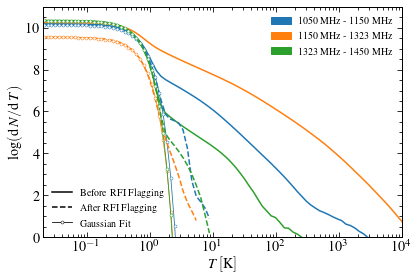

In [11]:
for DATA_Key, DATA, DATE in iter_data_key(DATA_Key_list):
    file_temp = '%s/%s_arcdrift'%(DATE, DATA)
    
    #fbins = [1050, 1135, 1310, 1450]
    fbins = [1050, 1150, 1323, 1450]
    
    file_root = data_base + '/sir_sumfeeds/'
    file_list_af = [
        [ file_root + '%s%04d-%04d%s.h5'%(file_temp, i, i, band_list[0]) for i in range(1, 8) ],
        [ file_root + '%s%04d-%04d%s.h5'%(file_temp, i, i, band_list[1]) for i in range(1, 8) ],
        [ file_root + '%s%04d-%04d%s.h5'%(file_temp, i, i, band_list[2]) for i in range(1, 8) ],
    ]
    hist_file = data_base + '/rfi_hist/sir_sumfeeds_%s_full.h5'%file_temp.replace('/', '_')
    pr.output_rfi_hist(file_list_af, fbins=fbins, output=hist_file)
    fig_output = data_base + '/plot/rfi_hist_sir_sumfeeds_%s.png'%file_temp.replace('/', '_')
    pr.plot_rfi_hist_multi(hist_file, output=fig_output)

In [ ]:
file_root = data_base + '/rf_sumfeeds/'
file_list_af = [
    [ file_root + '%s%04d-%04d_%s.h5'%(file_temp, i, i, b[0]) for i in range(1, 8) ],
    [ file_root + '%s%04d-%04d_%s.h5'%(file_temp, i, i, b[1]) for i in range(1, 8) ],
    [ file_root + '%s%04d-%04d_%s.h5'%(file_temp, i, i, b[2]) for i in range(1, 8) ],
]
hist_file = data_base + '/rfi_hist/sth_sumfeeds_%s_full.h5'%file_temp.replace('/', '_')
pr.output_rfi_hist(file_list_af, fbins=fbins, output=hist_file)
fig_output = data_base + '/plot/rfi_hist_sth_sumfeeds_%s.png'%file_temp.replace('/', '_')
pr.plot_rfi_hist_multi(hist_file, output=fig_output)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[12199.25    8642.578   8862.829  11853.85    9114.407   7842.0776
   5553.64    8422.172   6552.76    6778.4053 15578.17    7096.8286
   6038.9814  4218.531   4177.44    6573.5796  6254.0723 10901.774
   8577.614 ]
 [ 5680.512   6785.1807 12426.721   7805.051   9182.245   4974.0244
   9173.889  12476.136  10119.442  11113.836  11096.158  12128.449
   6444.702   3869.3704  6962.011   3152.751   4137.019   7889.7344
   5880.824 ]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[526.6566  432.49585 391.8371  327.6699  516.1873  286.5699  325.82864
  511.69897 397.6012  394.52914 310.1183  419.9073  327.9851  285.02832
  419.5458  409.69226 588.35516 435.60217 310.8179 ]
 [258.70535 234.65059 284.715   321.27408 256.92065 302.29874 243.46278
  268.40985 276.21164 339.13654 318.31372 218.37323 2